In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# LSTM Multivariate
Using lookback = 1

## Load and prepare the data

In [2]:
df = pd.read_csv('../cleaned_data/TLKM.csv', index_col='Date', parse_dates=True)
df.head()

,7 DAYS MA,14 DAYS MA,21 DAYS MA,7 DAYS STD DEV,RSI 7,RSI 14,RSI 21,MFI 7,MFI 14,MFI 21,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Close
Date,,,,,,,,,,,,,,,,,,
2012-10-17,-1.257411,-1.265240,-1.272727,-0.808345,0.491269,0.706085,0.927517,0.696955,1.053230,1.012777,0.0,0.5,0.5,-1.0,0.594005,0.066667,0.592593,-1.248980
2012-10-18,-1.253889,-1.260517,-1.269972,-0.830223,-0.014190,0.278954,0.557617,0.054518,0.628572,0.633022,0.5,0.5,0.5,-1.0,0.599455,0.133333,0.592593,-1.265306
2012-10-19,-1.253889,-1.258155,-1.268005,-0.830223,-0.014190,0.278954,0.557617,0.319828,0.968469,0.918278,1.0,0.5,0.5,-1.0,0.604905,0.200000,0.592593,-1.265306
2012-10-22,-1.253889,-1.255203,-1.266037,-0.830223,-0.491719,-0.129789,0.200645,-0.324491,0.591624,0.640169,-1.0,0.5,0.5,-1.0,0.621253,0.400000,0.629630,-1.281633
2012-10-23,-1.258585,-1.254613,-1.264856,-0.760737,0.022975,0.231437,0.483864,-0.324491,0.429086,0.803149,-0.5,0.5,0.5,-1.0,0.626703,0.466667,0.629630,-1.265306


### Split the dataset into train and test

In [3]:
train_len = int(len(df)*.8)
train_dataset = df[:train_len]
test_dataset = df[train_len:len(df)]

In [4]:
train_y = train_dataset[['Close']]

### Create the train dataset

In [5]:
hops = 1
train_len = len(train_dataset)

X_train = []
y_train = []

for i in range(hops, train_len):
    X_train.append(train_dataset[i-hops:i])
    y_train.append(train_y.iloc[i][0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [6]:
X_train.shape

(1966, 1, 18)

In [7]:
y_train.shape

(1966,)

**Reshape the X_train into 3d**
Required for LSTM

In [8]:
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_train_reshaped.shape

(1966, 1, 18)

### Create the test dataset

In [9]:
train_dataset_last_hops = train_dataset.iloc[-1*hops:]
test_dataset_full = test_dataset.copy()
test_dataset_full = pd.concat((train_dataset_last_hops, test_dataset_full), axis=0)

In [10]:
test_dataset_full_y = test_dataset_full[['Close']]

In [11]:
test_len = test_dataset_full.shape[0]

X_test = []
y_test = []

for i in range(hops, test_len):
    X_test.append(test_dataset_full[i-hops:i])
    y_test.append(test_dataset_full_y.iloc[i][0])
    
X_test, y_test = np.array(X_test), np.array(y_test)

In [12]:
X_test.shape

(492, 1, 18)

## Modeling with LSTM

In [13]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [14]:
def build_model(lstm_unit1, lstm_unit2, hops):
    """
    Function to build LSTM model architecture
    """
    model = Sequential()
    model.add(LSTM(units=lstm_unit1, return_sequences=True, input_shape=(hops,18)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=lstm_unit2))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    print(model.summary())
    return model

In [15]:
def fit_model(model, X_train, y_train, epochs, batch_size):
    """
    Function to fit the model with specified epochs and batch size
    """
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    return history

In [16]:
def predict(model, X_test):
    predictions = model.predict(X_test)
    actual_close = df[['Close']]
    actual_close = pd.DataFrame(actual_close.iloc[train_len:, 0])
    predictions = pd.DataFrame(predictions)
    predictions.reset_index(drop=True, inplace=True)
    predictions.index = test_dataset.index
    predictions['Actual'] = actual_close['Close']
    predictions.rename(columns={0:'Pred'}, inplace=True)
    return predictions

In [17]:
def plot_pred_act(predictions_df):
    """
    Function to plot and compare y_true and y_pred
    """
    plt.title('True vs Predicted')
    predictions_df['Actual'].plot(figsize=(20,8), legend=True, color='blue')
    predictions_df['Pred'].plot(legend=True, color='red', figsize=(20,8))
    plt.legend(loc='best')
    plt.xlabel('Standardized Close Price')
    plt.show()

In [18]:
from joblib import load

close_scaler = load('../feature_engineering/tlkm_close_scaler.bin')

In [19]:
def inverse_pred_act(predictions_df):
    """
    Function to inverse standardized Close value
    """
    inversed_pred = close_scaler.inverse_transform(np.array(predictions_df['Pred']).reshape(-1,1))
    inversed_act = close_scaler.inverse_transform(np.array(predictions_df['Actual']).reshape(-1,1))
    inversed = pd.DataFrame(inversed_pred)
    inversed['Actual'] = inversed_act
    inversed.rename({0:'Pred'}, axis=1, inplace=True)
    inversed.index = test_dataset.index
    return inversed

In [20]:
def plotErrorHist(inversed_df):
    """
    Function to plot error histogram
    """
    error = inversed_df['Pred'] - inversed_df['Actual']
    # plt.hist(error, bins=25)
    plt.figure(figsize=(15,12))
    sns.displot(error)
    plt.xlabel('Prediction Error [Close]')
    _ = plt.ylabel('Count')

In [21]:
"""
Evaluation metrics
"""
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [22]:
def evaluate(inversed_df):
    """
    Function to evaluate predictions
    """
    rmse_ = rmse(inversed_df['Actual'], inversed_df['Pred'])
    mape_ = mape(inversed_df['Actual'], inversed_df['Pred'])
    r2 = r2_score(inversed_df['Actual'], inversed_df['Pred'])
    return rmse_, mape_, r2

In [23]:
epochs_candidates = [100,150,200]
batch_size_candidates = [16,32,64]
lstm_unit1_candidates = [50, 100]
lstm_unit2_candidates = [50, 100]

In [24]:
models = {}
predictions_dfs = {}
inversed_dfs = {}
performances = {}

In [25]:
modelID = 1
for e in epochs_candidates:
    for b in batch_size_candidates:
        for l1 in lstm_unit1_candidates:
            for l2 in lstm_unit2_candidates:
                model = build_model(lstm_unit1=l1, lstm_unit2=l2, hops=1)
                history = fit_model(model, X_train, y_train, epochs=e, batch_size=b)
                models[f'Model-{modelID}'] = (model, history)
                
                predictions = predict(model, X_test)
                predictions_dfs[f'Model-{modelID}'] = predictions
                
                inversed = inverse_pred_act(predictions)
                inversed_dfs[f'Model-{modelID}'] = inversed
                rmse_, mape_, r2 = evaluate(inversed)
                
                performances[f'Model-{modelID}'] = {
                    'epochs': e,
                    'batch size': b,
                    'lstm unit 1': l1,
                    'lstm unit 2': l2,
                    'RMSE': rmse_,
                    'MAPE': mape_,
                    'r2': r2
                }
                modelID += 1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             13800     
                                                                 
 dropout (Dropout)           (None, 1, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 34,051
Trainable params: 34,051
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
123/123 [==========================

123/123 [==============================] - 1s 10ms/step - loss: 0.0063
Epoch 86/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0059
Epoch 87/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0061
Epoch 88/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0066
Epoch 89/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0059
Epoch 90/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0060
Epoch 91/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0063
Epoch 92/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0064
Epoch 93/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0061
Epoch 94/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0059
Epoch 95/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0062
Epoch 96/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0060
Epoch 

123/123 [==============================] - 1s 10ms/step - loss: 0.0053
Epoch 70/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0054
Epoch 71/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0052
Epoch 72/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0057
Epoch 73/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0054
Epoch 74/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0058
Epoch 75/100
123/123 [==============================] - 1s 11ms/step - loss: 0.0053
Epoch 76/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0053
Epoch 77/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0052
Epoch 78/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0055
Epoch 79/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0056
Epoch 80/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0057
Epoch 81/

123/123 [==============================] - 1s 10ms/step - loss: 0.0060
Epoch 54/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0056
Epoch 55/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0058
Epoch 56/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0056
Epoch 57/100
123/123 [==============================] - 1s 11ms/step - loss: 0.0057
Epoch 58/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0059
Epoch 59/100
123/123 [==============================] - 1s 11ms/step - loss: 0.0059
Epoch 60/100
123/123 [==============================] - 1s 11ms/step - loss: 0.0058
Epoch 61/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0057
Epoch 62/100
123/123 [==============================] - 1s 12ms/step - loss: 0.0059
Epoch 63/100
123/123 [==============================] - 1s 11ms/step - loss: 0.0058
Epoch 64/100
123/123 [==============================] - 1s 11ms/step - loss: 0.0060
Epoch 6

123/123 [==============================] - 1s 10ms/step - loss: 0.0049
Epoch 38/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0051
Epoch 39/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0052
Epoch 40/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0047
Epoch 41/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0050
Epoch 42/100
123/123 [==============================] - 1s 11ms/step - loss: 0.0047
Epoch 43/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0051
Epoch 44/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0051
Epoch 45/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0051
Epoch 46/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0050
Epoch 47/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0049
Epoch 48/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0050
Epoch

62/62 [==============================] - 1s 10ms/step - loss: 0.0073
Epoch 22/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0076
Epoch 23/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0077
Epoch 24/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0075
Epoch 25/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0072
Epoch 26/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0074
Epoch 27/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0070
Epoch 28/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0071
Epoch 29/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0070
Epoch 30/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0071
Epoch 31/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0067
Epoch 32/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0071
Epoch 33/100
62/62 [=========

62/62 [==============================] - 1s 11ms/step - loss: 0.0074
Epoch 8/100
62/62 [==============================] - 1s 12ms/step - loss: 0.0072
Epoch 9/100
62/62 [==============================] - 1s 12ms/step - loss: 0.0071
Epoch 10/100
62/62 [==============================] - 1s 12ms/step - loss: 0.0069
Epoch 11/100
62/62 [==============================] - 1s 12ms/step - loss: 0.0066
Epoch 12/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0066
Epoch 13/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0063
Epoch 14/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0062
Epoch 15/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0062
Epoch 16/100
62/62 [==============================] - 1s 8ms/step - loss: 0.0063
Epoch 17/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0063
Epoch 18/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0060
Epoch 19/100
62/62 [============

 lstm_13 (LSTM)              (None, 50)                30200     
                                                                 
 dropout_13 (Dropout)        (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 77,851
Trainable params: 77,851
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
62/62 [==============================] - 17s 12ms/step - loss: 0.1653
Epoch 2/100
62/62 [==============================] - 1s 9ms/step - loss: 0.0095
Epoch 3/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0079
Epoch 4/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0077
Epoch 5/100
62/62 [==============================] - 1s 12ms/step - loss: 0.0076
Epoch 6/100
62/62 [==============================] - 1s 12

62/62 [==============================] - 1s 10ms/step - loss: 0.0055
Epoch 94/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0055
Epoch 95/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0055
Epoch 96/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0058
Epoch 97/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0058
Epoch 98/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0056
Epoch 99/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0060
Epoch 100/100
16/16 [==============================] - 3s 6ms/step
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 1, 100)            47600     
                                                                 
 dropout_14 (Dropout)        (None, 1, 100)            0         
                    

62/62 [==============================] - 1s 11ms/step - loss: 0.0045
Epoch 80/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0049
Epoch 81/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0050
Epoch 82/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0045
Epoch 83/100
62/62 [==============================] - 1s 12ms/step - loss: 0.0047
Epoch 84/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0046
Epoch 85/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0045
Epoch 86/100
62/62 [==============================] - 1s 12ms/step - loss: 0.0047
Epoch 87/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0045
Epoch 88/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0043
Epoch 89/100
62/62 [==============================] - 1s 12ms/step - loss: 0.0046
Epoch 90/100
62/62 [==============================] - 1s 12ms/step - loss: 0.0045
Epoch 91/100
62/62 [=========

31/31 [==============================] - 0s 12ms/step - loss: 0.0070
Epoch 66/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0068
Epoch 67/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0064
Epoch 68/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0067
Epoch 69/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0064
Epoch 70/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0069
Epoch 71/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0060
Epoch 72/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0068
Epoch 73/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0064
Epoch 74/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0064
Epoch 75/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0066
Epoch 76/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0065
Epoch 77/100
31/31 [==========

31/31 [==============================] - 0s 13ms/step - loss: 0.0054
Epoch 52/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0054
Epoch 53/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0060
Epoch 54/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0058
Epoch 55/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0056
Epoch 56/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0059
Epoch 57/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0058
Epoch 58/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0054
Epoch 59/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0056
Epoch 60/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0056
Epoch 61/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0057
Epoch 62/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0057
Epoch 63/100
31/31 [=========

31/31 [==============================] - 0s 12ms/step - loss: 0.0059
Epoch 38/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0058
Epoch 39/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0058
Epoch 40/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0060
Epoch 41/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0063
Epoch 42/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0060
Epoch 43/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0058
Epoch 44/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0055
Epoch 45/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0060
Epoch 46/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0057
Epoch 47/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0061
Epoch 48/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0058
Epoch 49/100
31/31 [=========

31/31 [==============================] - 0s 13ms/step - loss: 0.0052
Epoch 24/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0050
Epoch 25/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0053
Epoch 26/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0048
Epoch 27/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0052
Epoch 28/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0049
Epoch 29/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0050
Epoch 30/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0052
Epoch 31/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0050
Epoch 32/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0047
Epoch 33/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0047
Epoch 34/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0050
Epoch 35/100
31/31 [=========

123/123 [==============================] - 1s 9ms/step - loss: 0.0080
Epoch 10/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0081
Epoch 11/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0079
Epoch 12/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0076
Epoch 13/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0074
Epoch 14/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0082
Epoch 15/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0075
Epoch 16/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0073
Epoch 17/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0074
Epoch 18/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0069
Epoch 19/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0074
Epoch 20/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0072
Epoch 21/150
123

123/123 [==============================] - 1s 9ms/step - loss: 0.0061
Epoch 108/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0060
Epoch 109/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0063
Epoch 110/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0059
Epoch 111/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0063
Epoch 112/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0060
Epoch 113/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0060
Epoch 114/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0061
Epoch 115/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0062
Epoch 116/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0063
Epoch 117/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0059
Epoch 118/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0063
Epoch 

123/123 [==============================] - 1s 10ms/step - loss: 0.0058
Epoch 42/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0053
Epoch 43/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0058
Epoch 44/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0059
Epoch 45/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0059
Epoch 46/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0056
Epoch 47/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0060
Epoch 48/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0057
Epoch 49/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0055
Epoch 50/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0058
Epoch 51/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0053
Epoch 52/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0060
Epoch

123/123 [==============================] - 1s 10ms/step - loss: 0.0050
Epoch 139/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0055
Epoch 140/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0051
Epoch 141/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0049
Epoch 142/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0051
Epoch 143/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0050
Epoch 144/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0049
Epoch 145/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0051
Epoch 146/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0048
Epoch 147/150
123/123 [==============================] - 1s 11ms/step - loss: 0.0049
Epoch 148/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0050
Epoch 149/150
123/123 [==============================] - 1s 10ms/step - loss: 0.00

123/123 [==============================] - 1s 11ms/step - loss: 0.0057
Epoch 73/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0057
Epoch 74/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0056
Epoch 75/150
123/123 [==============================] - 1s 11ms/step - loss: 0.0054
Epoch 76/150
123/123 [==============================] - 1s 11ms/step - loss: 0.0062
Epoch 77/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0055
Epoch 78/150
123/123 [==============================] - 1s 11ms/step - loss: 0.0058
Epoch 79/150
123/123 [==============================] - 1s 11ms/step - loss: 0.0057
Epoch 80/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0057
Epoch 81/150
123/123 [==============================] - 1s 11ms/step - loss: 0.0052
Epoch 82/150
123/123 [==============================] - 1s 11ms/step - loss: 0.0060
Epoch 83/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0055
Epoch

123/123 [==============================] - 1s 10ms/step - loss: 0.0058
Epoch 6/150
123/123 [==============================] - 1s 11ms/step - loss: 0.0057
Epoch 7/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0057
Epoch 8/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0058
Epoch 9/150
123/123 [==============================] - 1s 11ms/step - loss: 0.0056
Epoch 10/150
123/123 [==============================] - 1s 11ms/step - loss: 0.0056
Epoch 11/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0050
Epoch 12/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0053
Epoch 13/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0053
Epoch 14/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0050
Epoch 15/150
123/123 [==============================] - 1s 11ms/step - loss: 0.0052
Epoch 16/150
123/123 [==============================] - 1s 11ms/step - loss: 0.0051
Epoch 17/1

123/123 [==============================] - 1s 11ms/step - loss: 0.0046
Epoch 103/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0044
Epoch 104/150
123/123 [==============================] - 1s 11ms/step - loss: 0.0045
Epoch 105/150
123/123 [==============================] - 1s 11ms/step - loss: 0.0044
Epoch 106/150
123/123 [==============================] - 1s 11ms/step - loss: 0.0045
Epoch 107/150
123/123 [==============================] - 1s 11ms/step - loss: 0.0044
Epoch 108/150
123/123 [==============================] - 1s 11ms/step - loss: 0.0049
Epoch 109/150
123/123 [==============================] - 1s 11ms/step - loss: 0.0044
Epoch 110/150
123/123 [==============================] - 1s 11ms/step - loss: 0.0045
Epoch 111/150
123/123 [==============================] - 1s 11ms/step - loss: 0.0044
Epoch 112/150
123/123 [==============================] - 1s 11ms/step - loss: 0.0046
Epoch 113/150
123/123 [==============================] - 1s 11ms/step - loss: 0

62/62 [==============================] - 1s 10ms/step - loss: 0.0072
Epoch 37/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0072
Epoch 38/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0067
Epoch 39/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0064
Epoch 40/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0066
Epoch 41/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0070
Epoch 42/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0072
Epoch 43/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0072
Epoch 44/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0072
Epoch 45/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0067
Epoch 46/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0068
Epoch 47/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0069
Epoch 48/150
62/62 [=========

62/62 [==============================] - 1s 10ms/step - loss: 0.0061
Epoch 136/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0055
Epoch 137/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0061
Epoch 138/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0061
Epoch 139/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0061
Epoch 140/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0064
Epoch 141/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0062
Epoch 142/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0061
Epoch 143/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0061
Epoch 144/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0060
Epoch 145/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0061
Epoch 146/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0062
Epoch 147/150
62/6

62/62 [==============================] - 1s 10ms/step - loss: 0.0055
Epoch 72/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0057
Epoch 73/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0054
Epoch 74/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0055
Epoch 75/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0051
Epoch 76/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0054
Epoch 77/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0052
Epoch 78/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0054
Epoch 79/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0054
Epoch 80/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0056
Epoch 81/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0056
Epoch 82/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0055
Epoch 83/150
62/62 [=========

62/62 [==============================] - 1s 12ms/step - loss: 0.0071
Epoch 7/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0067
Epoch 8/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0069
Epoch 9/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0067
Epoch 10/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0062
Epoch 11/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0065
Epoch 12/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0066
Epoch 13/150
62/62 [==============================] - 1s 13ms/step - loss: 0.0065
Epoch 14/150
62/62 [==============================] - 1s 12ms/step - loss: 0.0063
Epoch 15/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0062
Epoch 16/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0064
Epoch 17/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0060
Epoch 18/150
62/62 [============

62/62 [==============================] - 1s 11ms/step - loss: 0.0054
Epoch 107/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0059
Epoch 108/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0055
Epoch 109/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0055
Epoch 110/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0057
Epoch 111/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0051
Epoch 112/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0057
Epoch 113/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0058
Epoch 114/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0056
Epoch 115/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0054
Epoch 116/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0054
Epoch 117/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0058
Epoch 118/150
62/6

62/62 [==============================] - 1s 11ms/step - loss: 0.0047
Epoch 42/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0050
Epoch 43/150
62/62 [==============================] - 1s 12ms/step - loss: 0.0046
Epoch 44/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0050
Epoch 45/150
62/62 [==============================] - 1s 12ms/step - loss: 0.0052
Epoch 46/150
62/62 [==============================] - 1s 12ms/step - loss: 0.0049
Epoch 47/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0050
Epoch 48/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0044
Epoch 49/150
62/62 [==============================] - 1s 12ms/step - loss: 0.0049
Epoch 50/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0047
Epoch 51/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0046
Epoch 52/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0047
Epoch 53/150
62/62 [=========

62/62 [==============================] - 1s 12ms/step - loss: 0.0046
Epoch 141/150
62/62 [==============================] - 1s 12ms/step - loss: 0.0046
Epoch 142/150
62/62 [==============================] - 1s 12ms/step - loss: 0.0042
Epoch 143/150
62/62 [==============================] - 1s 12ms/step - loss: 0.0047
Epoch 144/150
62/62 [==============================] - 1s 12ms/step - loss: 0.0043
Epoch 145/150
62/62 [==============================] - 1s 13ms/step - loss: 0.0044
Epoch 146/150
62/62 [==============================] - 1s 12ms/step - loss: 0.0042
Epoch 147/150
62/62 [==============================] - 1s 12ms/step - loss: 0.0044
Epoch 148/150
62/62 [==============================] - 1s 12ms/step - loss: 0.0044
Epoch 149/150
62/62 [==============================] - 1s 12ms/step - loss: 0.0042
Epoch 150/150
16/16 [==============================] - 3s 6ms/step
Model: "sequential_20"
_________________________________________________________________
 Layer (type)               

31/31 [==============================] - 0s 11ms/step - loss: 0.0063
Epoch 77/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0063
Epoch 78/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0068
Epoch 79/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0067
Epoch 80/150
31/31 [==============================] - 0s 11ms/step - loss: 0.0065
Epoch 81/150
31/31 [==============================] - 0s 11ms/step - loss: 0.0067
Epoch 82/150
31/31 [==============================] - 0s 11ms/step - loss: 0.0066
Epoch 83/150
31/31 [==============================] - 0s 11ms/step - loss: 0.0062
Epoch 84/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0067
Epoch 85/150
31/31 [==============================] - 0s 11ms/step - loss: 0.0064
Epoch 86/150
31/31 [==============================] - 0s 11ms/step - loss: 0.0065
Epoch 87/150
31/31 [==============================] - 0s 11ms/step - loss: 0.0062
Epoch 88/150
31/31 [=========

31/31 [==============================] - 0s 13ms/step - loss: 0.0070
Epoch 12/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0070
Epoch 13/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0071
Epoch 14/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0069
Epoch 15/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0071
Epoch 16/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0062
Epoch 17/150
31/31 [==============================] - 0s 13ms/step - loss: 0.0063
Epoch 18/150
31/31 [==============================] - 0s 13ms/step - loss: 0.0067
Epoch 19/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0060
Epoch 20/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0064
Epoch 21/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0062
Epoch 22/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0063
Epoch 23/150
31/31 [=========

Epoch 111/150
31/31 [==============================] - 0s 14ms/step - loss: 0.0054
Epoch 112/150
31/31 [==============================] - 0s 10ms/step - loss: 0.0051
Epoch 113/150
31/31 [==============================] - 0s 11ms/step - loss: 0.0051
Epoch 114/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0054
Epoch 115/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0055
Epoch 116/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0052
Epoch 117/150
31/31 [==============================] - 0s 13ms/step - loss: 0.0054
Epoch 118/150
31/31 [==============================] - 0s 13ms/step - loss: 0.0051
Epoch 119/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0055
Epoch 120/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0048
Epoch 121/150
31/31 [==============================] - 0s 13ms/step - loss: 0.0051
Epoch 122/150
31/31 [==============================] - 0s 14ms/step - loss: 0.0051
Epoc

31/31 [==============================] - 0s 13ms/step - loss: 0.0061
Epoch 47/150
31/31 [==============================] - 0s 13ms/step - loss: 0.0060
Epoch 48/150
31/31 [==============================] - 0s 13ms/step - loss: 0.0057
Epoch 49/150
31/31 [==============================] - 0s 14ms/step - loss: 0.0058
Epoch 50/150
31/31 [==============================] - 0s 13ms/step - loss: 0.0055
Epoch 51/150
31/31 [==============================] - 0s 13ms/step - loss: 0.0057
Epoch 52/150
31/31 [==============================] - 0s 13ms/step - loss: 0.0055
Epoch 53/150
31/31 [==============================] - 0s 13ms/step - loss: 0.0058
Epoch 54/150
31/31 [==============================] - 0s 14ms/step - loss: 0.0058
Epoch 55/150
31/31 [==============================] - 0s 13ms/step - loss: 0.0053
Epoch 56/150
31/31 [==============================] - 0s 14ms/step - loss: 0.0060
Epoch 57/150
31/31 [==============================] - 0s 13ms/step - loss: 0.0056
Epoch 58/150
31/31 [=========

31/31 [==============================] - 0s 13ms/step - loss: 0.0055
Epoch 146/150
31/31 [==============================] - 0s 13ms/step - loss: 0.0055
Epoch 147/150
31/31 [==============================] - 0s 13ms/step - loss: 0.0057
Epoch 148/150
31/31 [==============================] - 0s 13ms/step - loss: 0.0056
Epoch 149/150
31/31 [==============================] - 0s 13ms/step - loss: 0.0054
Epoch 150/150
16/16 [==============================] - 3s 6ms/step
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 1, 100)            47600     
                                                                 
 dropout_46 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_47 (LSTM)              (None, 100)               80400     
                                               

31/31 [==============================] - 0s 13ms/step - loss: 0.0048
Epoch 82/150
31/31 [==============================] - 0s 14ms/step - loss: 0.0044
Epoch 83/150
31/31 [==============================] - 0s 14ms/step - loss: 0.0044
Epoch 84/150
31/31 [==============================] - 0s 14ms/step - loss: 0.0047
Epoch 85/150
31/31 [==============================] - 0s 14ms/step - loss: 0.0044
Epoch 86/150
31/31 [==============================] - 0s 14ms/step - loss: 0.0047
Epoch 87/150
31/31 [==============================] - 0s 14ms/step - loss: 0.0045
Epoch 88/150
31/31 [==============================] - 0s 15ms/step - loss: 0.0042
Epoch 89/150
31/31 [==============================] - 0s 14ms/step - loss: 0.0044
Epoch 90/150
31/31 [==============================] - 0s 14ms/step - loss: 0.0047
Epoch 91/150
31/31 [==============================] - 0s 14ms/step - loss: 0.0043
Epoch 92/150
31/31 [==============================] - 0s 14ms/step - loss: 0.0043
Epoch 93/150
31/31 [=========

123/123 [==============================] - 1s 11ms/step - loss: 0.0073
Epoch 17/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0076
Epoch 18/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0071
Epoch 19/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0076
Epoch 20/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0071
Epoch 21/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0075
Epoch 22/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0071
Epoch 23/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0066
Epoch 24/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0072
Epoch 25/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0068
Epoch 26/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0069
Epoch 27/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0074
Epoch 28

Epoch 114/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0060
Epoch 115/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0061
Epoch 116/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0062
Epoch 117/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0059
Epoch 118/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0061
Epoch 119/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0058
Epoch 120/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0058
Epoch 121/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0060
Epoch 122/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0054
Epoch 123/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0062
Epoch 124/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0060
Epoch 125/200
123/123 [==============================] - 1s 9ms/step - lo

                                                                 
Total params: 74,301
Trainable params: 74,301
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
123/123 [==============================] - 15s 11ms/step - loss: 0.1156
Epoch 2/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0089
Epoch 3/200
123/123 [==============================] - 1s 11ms/step - loss: 0.0080
Epoch 4/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0079
Epoch 5/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0074
Epoch 6/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0069
Epoch 7/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0068
Epoch 8/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0064
Epoch 9/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0066
Epoch 10/200
123/123 [=======================

123/123 [==============================] - 1s 10ms/step - loss: 0.0052
Epoch 96/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0054
Epoch 97/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0050
Epoch 98/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0052
Epoch 99/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0051
Epoch 100/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0055
Epoch 101/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0051
Epoch 102/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0049
Epoch 103/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0052
Epoch 104/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0052
Epoch 105/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0052
Epoch 106/200
123/123 [==============================] - 1s 10ms/step - loss: 0.005

123/123 [==============================] - 1s 10ms/step - loss: 0.0045
Epoch 192/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0050
Epoch 193/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0048
Epoch 194/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0047
Epoch 195/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0047
Epoch 196/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0047
Epoch 197/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0049
Epoch 198/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0048
Epoch 199/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0048
Epoch 200/200
16/16 [==============================] - 3s 6ms/step
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)            

123/123 [==============================] - 1s 10ms/step - loss: 0.0056
Epoch 76/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0053
Epoch 77/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0055
Epoch 78/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0056
Epoch 79/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0058
Epoch 80/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0057
Epoch 81/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0055
Epoch 82/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0054
Epoch 83/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0056
Epoch 84/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0053
Epoch 85/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0057
Epoch 86/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0054
Epoch

123/123 [==============================] - 1s 11ms/step - loss: 0.0052
Epoch 172/200
123/123 [==============================] - 1s 11ms/step - loss: 0.0052
Epoch 173/200
123/123 [==============================] - 1s 11ms/step - loss: 0.0053
Epoch 174/200
123/123 [==============================] - 1s 11ms/step - loss: 0.0053
Epoch 175/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0052
Epoch 176/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0054
Epoch 177/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0047
Epoch 178/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0049
Epoch 179/200
123/123 [==============================] - 1s 11ms/step - loss: 0.0054
Epoch 180/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0050
Epoch 181/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0050
Epoch 182/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0

123/123 [==============================] - 1s 10ms/step - loss: 0.0047
Epoch 55/200
123/123 [==============================] - 1s 11ms/step - loss: 0.0047
Epoch 56/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0049
Epoch 57/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0048
Epoch 58/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0050
Epoch 59/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0047
Epoch 60/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0047
Epoch 61/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0048
Epoch 62/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0046
Epoch 63/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0045
Epoch 64/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0047
Epoch 65/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0045
Epoch

123/123 [==============================] - 1s 10ms/step - loss: 0.0045
Epoch 152/200
123/123 [==============================] - 1s 11ms/step - loss: 0.0044
Epoch 153/200
123/123 [==============================] - 1s 11ms/step - loss: 0.0042
Epoch 154/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0042
Epoch 155/200
123/123 [==============================] - 1s 11ms/step - loss: 0.0043
Epoch 156/200
123/123 [==============================] - 1s 11ms/step - loss: 0.0045
Epoch 157/200
123/123 [==============================] - 1s 11ms/step - loss: 0.0040
Epoch 158/200
123/123 [==============================] - 1s 12ms/step - loss: 0.0044
Epoch 159/200
123/123 [==============================] - 1s 11ms/step - loss: 0.0040
Epoch 160/200
123/123 [==============================] - 1s 11ms/step - loss: 0.0043
Epoch 161/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0042
Epoch 162/200
123/123 [==============================] - 1s 10ms/step - loss: 0

62/62 [==============================] - 1s 10ms/step - loss: 0.0071
Epoch 36/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0068
Epoch 37/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0070
Epoch 38/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0071
Epoch 39/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0067
Epoch 40/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0068
Epoch 41/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0067
Epoch 42/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0065
Epoch 43/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0065
Epoch 44/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0072
Epoch 45/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0070
Epoch 46/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0071
Epoch 47/200
62/62 [=========

62/62 [==============================] - 1s 10ms/step - loss: 0.0063
Epoch 135/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0061
Epoch 136/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0061
Epoch 137/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0060
Epoch 138/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0060
Epoch 139/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0064
Epoch 140/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0059
Epoch 141/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0058
Epoch 142/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0058
Epoch 143/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0063
Epoch 144/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0061
Epoch 145/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0059
Epoch 146/200
62/6

62/62 [==============================] - 1s 11ms/step - loss: 0.0059
Epoch 20/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0063
Epoch 21/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0060
Epoch 22/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0062
Epoch 23/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0062
Epoch 24/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0057
Epoch 25/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0061
Epoch 26/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0062
Epoch 27/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0061
Epoch 28/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0063
Epoch 29/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0056
Epoch 30/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0059
Epoch 31/200
62/62 [=========

62/62 [==============================] - 1s 10ms/step - loss: 0.0050
Epoch 119/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0053
Epoch 120/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0052
Epoch 121/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0051
Epoch 122/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0053
Epoch 123/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0050
Epoch 124/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0055
Epoch 125/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0050
Epoch 126/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0050
Epoch 127/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0049
Epoch 128/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0048
Epoch 129/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0050
Epoch 130/200
62/6

62/62 [==============================] - 1s 11ms/step - loss: 0.0077
Epoch 4/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0076
Epoch 5/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0069
Epoch 6/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0067
Epoch 7/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0066
Epoch 8/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0072
Epoch 9/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0065
Epoch 10/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0065
Epoch 11/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0062
Epoch 12/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0062
Epoch 13/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0063
Epoch 14/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0063
Epoch 15/200
62/62 [===============

62/62 [==============================] - 1s 10ms/step - loss: 0.0057
Epoch 104/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0055
Epoch 105/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0056
Epoch 106/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0056
Epoch 107/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0053
Epoch 108/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0056
Epoch 109/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0056
Epoch 110/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0055
Epoch 111/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0055
Epoch 112/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0058
Epoch 113/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0055
Epoch 114/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0058
Epoch 115/200
62/6

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 1, 100)            47600     
                                                                 
 dropout_62 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_63 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_63 (Dropout)        (None, 100)               0         
                                                                 
 dense_31 (Dense)            (None, 1)                 101       
                                                                 
Total params: 128,101
Trainable params: 128,101
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
62/62 [==============================] - 14s 12ms/ste

Epoch 88/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0044
Epoch 89/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0043
Epoch 90/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0044
Epoch 91/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0044
Epoch 92/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0047
Epoch 93/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0048
Epoch 94/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0045
Epoch 95/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0044
Epoch 96/200
62/62 [==============================] - 1s 11ms/step - loss: 0.0045
Epoch 97/200
62/62 [==============================] - 1s 12ms/step - loss: 0.0044
Epoch 98/200
62/62 [==============================] - 1s 12ms/step - loss: 0.0044
Epoch 99/200
62/62 [==============================] - 1s 14ms/step - loss: 0.0048
Epoch 100/200
62

62/62 [==============================] - 1s 12ms/step - loss: 0.0045
Epoch 187/200
62/62 [==============================] - 1s 12ms/step - loss: 0.0041
Epoch 188/200
62/62 [==============================] - 1s 12ms/step - loss: 0.0042
Epoch 189/200
62/62 [==============================] - 1s 13ms/step - loss: 0.0042
Epoch 190/200
62/62 [==============================] - 1s 12ms/step - loss: 0.0040
Epoch 191/200
62/62 [==============================] - 1s 12ms/step - loss: 0.0042
Epoch 192/200
62/62 [==============================] - 1s 12ms/step - loss: 0.0042
Epoch 193/200
62/62 [==============================] - 1s 12ms/step - loss: 0.0041
Epoch 194/200
62/62 [==============================] - 1s 12ms/step - loss: 0.0045
Epoch 195/200
62/62 [==============================] - 1s 12ms/step - loss: 0.0040
Epoch 196/200
62/62 [==============================] - 1s 12ms/step - loss: 0.0043
Epoch 197/200
62/62 [==============================] - 1s 12ms/step - loss: 0.0043
Epoch 198/200
62/6

31/31 [==============================] - 0s 11ms/step - loss: 0.0066
Epoch 73/200
31/31 [==============================] - 0s 11ms/step - loss: 0.0062
Epoch 74/200
31/31 [==============================] - 0s 11ms/step - loss: 0.0063
Epoch 75/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0066
Epoch 76/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0069
Epoch 77/200
31/31 [==============================] - 0s 11ms/step - loss: 0.0062
Epoch 78/200
31/31 [==============================] - 0s 11ms/step - loss: 0.0066
Epoch 79/200
31/31 [==============================] - 0s 11ms/step - loss: 0.0068
Epoch 80/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0067
Epoch 81/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0065
Epoch 82/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0065
Epoch 83/200
31/31 [==============================] - 0s 11ms/step - loss: 0.0066
Epoch 84/200
31/31 [=========

31/31 [==============================] - 0s 11ms/step - loss: 0.0060
Epoch 172/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0063
Epoch 173/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0060
Epoch 174/200
31/31 [==============================] - 0s 13ms/step - loss: 0.0059
Epoch 175/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0059
Epoch 176/200
31/31 [==============================] - 0s 11ms/step - loss: 0.0058
Epoch 177/200
31/31 [==============================] - 0s 11ms/step - loss: 0.0066
Epoch 178/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0062
Epoch 179/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0059
Epoch 180/200
31/31 [==============================] - 0s 11ms/step - loss: 0.0064
Epoch 181/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0061
Epoch 182/200
31/31 [==============================] - 0s 11ms/step - loss: 0.0058
Epoch 183/200
31/3

31/31 [==============================] - 0s 12ms/step - loss: 0.0057
Epoch 57/200
31/31 [==============================] - 0s 13ms/step - loss: 0.0060
Epoch 58/200
31/31 [==============================] - 0s 13ms/step - loss: 0.0058
Epoch 59/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0058
Epoch 60/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0055
Epoch 61/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0061
Epoch 62/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0059
Epoch 63/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0057
Epoch 64/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0059
Epoch 65/200
31/31 [==============================] - 0s 13ms/step - loss: 0.0055
Epoch 66/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0053
Epoch 67/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0055
Epoch 68/200
31/31 [=========

31/31 [==============================] - 0s 12ms/step - loss: 0.0054
Epoch 156/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0054
Epoch 157/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0053
Epoch 158/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0052
Epoch 159/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0053
Epoch 160/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0051
Epoch 161/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0050
Epoch 162/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0055
Epoch 163/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0049
Epoch 164/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0052
Epoch 165/200
31/31 [==============================] - 0s 13ms/step - loss: 0.0050
Epoch 166/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0051
Epoch 167/200
31/3

31/31 [==============================] - 0s 12ms/step - loss: 0.0057
Epoch 41/200
31/31 [==============================] - 0s 13ms/step - loss: 0.0058
Epoch 42/200
31/31 [==============================] - 0s 13ms/step - loss: 0.0061
Epoch 43/200
31/31 [==============================] - 0s 13ms/step - loss: 0.0057
Epoch 44/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0058
Epoch 45/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0053
Epoch 46/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0061
Epoch 47/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0062
Epoch 48/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0059
Epoch 49/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0059
Epoch 50/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0059
Epoch 51/200
31/31 [==============================] - 0s 13ms/step - loss: 0.0060
Epoch 52/200
31/31 [=========

31/31 [==============================] - 0s 12ms/step - loss: 0.0057
Epoch 140/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0051
Epoch 141/200
31/31 [==============================] - 0s 13ms/step - loss: 0.0054
Epoch 142/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0053
Epoch 143/200
31/31 [==============================] - 0s 13ms/step - loss: 0.0057
Epoch 144/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0060
Epoch 145/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0055
Epoch 146/200
31/31 [==============================] - 0s 13ms/step - loss: 0.0052
Epoch 147/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0053
Epoch 148/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0055
Epoch 149/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0057
Epoch 150/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0052
Epoch 151/200
31/3

31/31 [==============================] - 0s 13ms/step - loss: 0.0051
Epoch 25/200
31/31 [==============================] - 0s 15ms/step - loss: 0.0051
Epoch 26/200
31/31 [==============================] - 0s 15ms/step - loss: 0.0046
Epoch 27/200
31/31 [==============================] - 0s 13ms/step - loss: 0.0049
Epoch 28/200
31/31 [==============================] - 0s 13ms/step - loss: 0.0051
Epoch 29/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0049
Epoch 30/200
31/31 [==============================] - 0s 15ms/step - loss: 0.0046
Epoch 31/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0047
Epoch 32/200
31/31 [==============================] - 0s 13ms/step - loss: 0.0049
Epoch 33/200
31/31 [==============================] - 0s 13ms/step - loss: 0.0048
Epoch 34/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0049
Epoch 35/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0050
Epoch 36/200
31/31 [=========

31/31 [==============================] - 0s 15ms/step - loss: 0.0045
Epoch 124/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0042
Epoch 125/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0046
Epoch 126/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0046
Epoch 127/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0046
Epoch 128/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0042
Epoch 129/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0045
Epoch 130/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0047
Epoch 131/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0044
Epoch 132/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0044
Epoch 133/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0046
Epoch 134/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0046
Epoch 135/200
31/3

In [26]:
perf_df = pd.DataFrame(performances)
perf_df = perf_df.transpose()

In [27]:
perf_df.sort_values('RMSE')

,epochs,batch size,lstm unit 1,lstm unit 2,RMSE,MAPE,r2
Model-6,100.0,32.0,50.0,100.0,73.143883,1.537542,0.983387
Model-36,200.0,64.0,100.0,100.0,73.475922,1.486368,0.983235
Model-1,100.0,16.0,50.0,50.0,74.988396,1.551694,0.982538
Model-23,150.0,64.0,100.0,50.0,75.583607,1.531416,0.982260
Model-19,150.0,32.0,100.0,50.0,75.788677,1.540744,0.982163
Model-8,100.0,32.0,100.0,100.0,76.296628,1.548966,0.981923
Model-33,200.0,64.0,50.0,50.0,76.400017,1.579798,0.981874
Model-20,150.0,32.0,100.0,100.0,76.618674,1.556824,0.981771
Model-4,100.0,16.0,100.0,100.0,77.600737,1.568613,0.981300
Model-17,150.0,32.0,50.0,50.0,77.986660,1.632824,0.981114


**Best model**

In [28]:
perf_df.sort_values('RMSE').iloc[0:3]

,epochs,batch size,lstm unit 1,lstm unit 2,RMSE,MAPE,r2
Model-6,100.0,32.0,50.0,100.0,73.143883,1.537542,0.983387
Model-36,200.0,64.0,100.0,100.0,73.475922,1.486368,0.983235
Model-1,100.0,16.0,50.0,50.0,74.988396,1.551694,0.982538


<Figure size 1080x864 with 0 Axes>

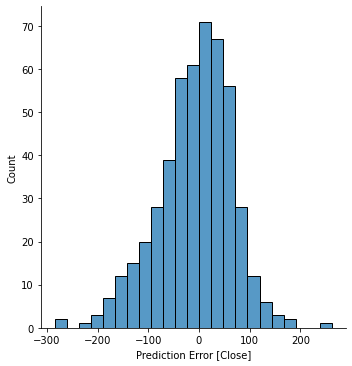

In [30]:
plotErrorHist(inversed_dfs['Model-6'])

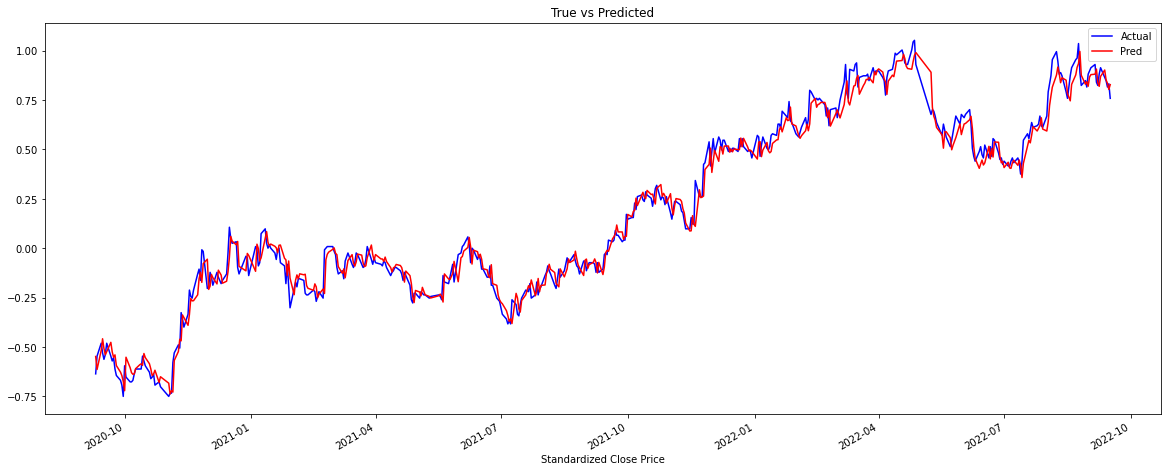

In [31]:
plot_pred_act(predictions_dfs['Model-6'])

## Save the best model

In [32]:
import keras

In [33]:
models['Model-6'][0].save('./models/tlkm.h5')

In [34]:
loadedModel = keras.models.load_model('./models/tlkm.h5')

In [35]:
loadedModel.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 1, 50)             13800     
                                                                 
 dropout_10 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_11 (LSTM)              (None, 100)               60400     
                                                                 
 dropout_11 (Dropout)        (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 74,301
Trainable params: 74,301
Non-trainable params: 0
_________________________________________________________________


In [36]:
yhat = loadedModel.predict(X_test)

16/16 [==============================] - 3s 6ms/step
